Доброго времени суток!

Обучение я проводил на своем компьютере, а значит, чтобы получить мои результаты, не получится просто перезапустить мой код из-за того, что у Вас может отличаться место хранения данных.

По аналогии с прошлыми домашними заданиями, я использовал notebook deep learning school. Дальнешие комментарии в коде.

In [18]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [19]:
import pickle
import numpy as np
import pandas as pd

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [20]:
from torchvision import transforms

In [21]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 128
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [22]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [23]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [24]:
# загрузка путей для данных
TRAIN_DIR = Path('./data/journey-springfield/train/simpsons_dataset/')
TEST_DIR = Path('./data/journey-springfield/testset/testset/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [39]:
# разбитие тренировочных данных на train и valid
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, train_size=0.99,stratify=train_val_labels)

In [42]:
train_val_files

[PosixPath('data/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg'),
 PosixPath('data/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0001.jpg'),
 PosixPath('data/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0002.jpg'),
 PosixPath('data/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0003.jpg'),
 PosixPath('data/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0004.jpg'),
 PosixPath('data/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0005.jpg'),
 PosixPath('data/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0006.jpg'),
 PosixPath('data/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0007.jpg'),
 PosixPath('data/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0008.jpg'),
 PosixPath('data/journey-springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0009.jpg'),
 PosixPath

In [9]:
# получение тестирующих данных
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

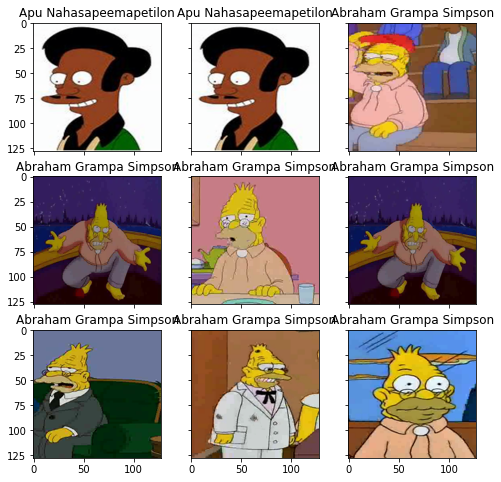

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,10))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [26]:
# обучение одной эпохи
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [27]:
# предсказания в конце эпохи
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [28]:
# обучение модели
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    
    return history

In [29]:
# предсказания модели
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

**Сначала прописывал архитектуры сам, но выше 94.2 % качества не получал. Потом я обратился к готовым архитектурам в torchvision.**
Тестируя различные варианты, пришел к лучшем предсказаниям у densnet201 с градиентным оптимизатором Adam  с дефолтными настройками.

In [30]:
from torchvision import models

In [31]:
np.unique(train_val_labels)

array(['abraham_grampa_simpson', 'agnes_skinner',
       'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson',
       'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum',
       'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel',
       'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson',
       'kent_brockman', 'krusty_the_clown', 'lenny_leonard',
       'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson',
       'martin_prince', 'mayor_quimby', 'milhouse_van_houten',
       'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz',
       'otto_mann', 'patty_bouvier', 'principal_skinner',
       'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum',
       'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird',
       'troy_mcclure', 'waylon_smithers'], dtype='<U24')

In [32]:
n_classes = len(np.unique(train_val_labels))
model_cnn = models.densenet201(num_classes=n_classes).to(DEVICE)

In [43]:
#model_cnn.load_state_dict( torch.load('./model/model_2_1_densnet201'))

In [33]:
print("we will classify :{}".format(n_classes))
print(model_cnn)

we will classify :42
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stat

Запустим обучение сети.

In [43]:
#if val_dataset is None:
#    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_val_files, mode='train')

In [44]:
history_den = train(train_dataset, val_dataset, model=model_cnn, epochs=26, batch_size=32)

epoch:   0%|          | 0/26 [00:00<?, ?it/s]

loss 1.626955553155357


epoch:   4%|▍         | 1/26 [12:10<5:04:13, 730.14s/it]


Epoch 001 train_loss: 1.6270     val_loss 9.4741 train_acc 0.5652 val_acc 0.0286
loss 1.1171520864041542


epoch:   8%|▊         | 2/26 [24:19<4:51:47, 729.47s/it]


Epoch 002 train_loss: 1.1172     val_loss 11.9433 train_acc 0.6904 val_acc 0.0238
loss 0.6137868575454584


epoch:  12%|█▏        | 3/26 [36:31<4:40:04, 730.61s/it]


Epoch 003 train_loss: 0.6138     val_loss 12.5202 train_acc 0.8290 val_acc 0.0381
loss 0.4820886504369362


epoch:  15%|█▌        | 4/26 [48:45<4:28:23, 731.99s/it]


Epoch 004 train_loss: 0.4821     val_loss 14.0333 train_acc 0.8654 val_acc 0.0429
loss 0.36863456045807347


epoch:  19%|█▉        | 5/26 [1:00:59<4:16:32, 732.99s/it]


Epoch 005 train_loss: 0.3686     val_loss 16.2943 train_acc 0.8947 val_acc 0.0429
loss 0.3049744978210391


epoch:  23%|██▎       | 6/26 [1:13:13<4:04:21, 733.07s/it]


Epoch 006 train_loss: 0.3050     val_loss 16.9474 train_acc 0.9133 val_acc 0.0429
loss 0.24724097628895098


epoch:  27%|██▋       | 7/26 [1:25:26<3:52:10, 733.19s/it]


Epoch 007 train_loss: 0.2472     val_loss 20.0382 train_acc 0.9301 val_acc 0.0429
loss 0.19485161545017196


epoch:  31%|███       | 8/26 [1:37:35<3:39:34, 731.93s/it]


Epoch 008 train_loss: 0.1949     val_loss 18.8953 train_acc 0.9427 val_acc 0.0429
loss 0.16014831922244518


epoch:  35%|███▍      | 9/26 [1:49:40<3:26:45, 729.74s/it]


Epoch 009 train_loss: 0.1601     val_loss 22.5135 train_acc 0.9530 val_acc 0.0429
loss 0.14804427555582


epoch:  38%|███▊      | 10/26 [2:01:44<3:14:05, 727.87s/it]


Epoch 010 train_loss: 0.1480     val_loss 22.2484 train_acc 0.9552 val_acc 0.0333
loss 0.11055257815430053


epoch:  42%|████▏     | 11/26 [2:13:48<3:01:38, 726.55s/it]


Epoch 011 train_loss: 0.1106     val_loss 24.1393 train_acc 0.9673 val_acc 0.0381
loss 0.11711396593951098


epoch:  46%|████▌     | 12/26 [2:25:51<2:49:18, 725.57s/it]


Epoch 012 train_loss: 0.1171     val_loss 20.3238 train_acc 0.9660 val_acc 0.0429
loss 0.08337359167792492


epoch:  50%|█████     | 13/26 [2:37:52<2:36:56, 724.37s/it]


Epoch 013 train_loss: 0.0834     val_loss 26.1904 train_acc 0.9753 val_acc 0.0429
loss 0.07373491028437111


epoch:  54%|█████▍    | 14/26 [2:49:54<2:24:41, 723.47s/it]


Epoch 014 train_loss: 0.0737     val_loss 27.9781 train_acc 0.9784 val_acc 0.0429
loss 0.0898444580320701


epoch:  58%|█████▊    | 15/26 [3:02:02<2:12:54, 724.91s/it]


Epoch 015 train_loss: 0.0898     val_loss 23.0821 train_acc 0.9738 val_acc 0.0429
loss 0.06381190858854925


epoch:  62%|██████▏   | 16/26 [3:14:11<2:00:59, 725.96s/it]


Epoch 016 train_loss: 0.0638     val_loss 26.5371 train_acc 0.9810 val_acc 0.0429
loss 0.06501544671693876


epoch:  65%|██████▌   | 17/26 [3:26:19<1:48:59, 726.67s/it]


Epoch 017 train_loss: 0.0650     val_loss 27.0888 train_acc 0.9808 val_acc 0.0429
loss 0.05787541660328047


epoch:  69%|██████▉   | 18/26 [3:38:27<1:36:56, 727.12s/it]


Epoch 018 train_loss: 0.0579     val_loss 32.6175 train_acc 0.9817 val_acc 0.0476
loss 0.048289583985327976


epoch:  73%|███████▎  | 19/26 [3:50:35<1:24:52, 727.49s/it]


Epoch 019 train_loss: 0.0483     val_loss 28.4279 train_acc 0.9857 val_acc 0.0429
loss 0.07284783871566439


epoch:  77%|███████▋  | 20/26 [4:02:44<1:12:46, 727.79s/it]


Epoch 020 train_loss: 0.0728     val_loss 29.6003 train_acc 0.9785 val_acc 0.0429
loss 0.03965246697714151


epoch:  81%|████████  | 21/26 [4:14:52<1:00:40, 728.03s/it]


Epoch 021 train_loss: 0.0397     val_loss 33.4906 train_acc 0.9877 val_acc 0.0429
loss 0.04670382725503254


epoch:  85%|████████▍ | 22/26 [4:27:01<48:32, 728.17s/it]  


Epoch 022 train_loss: 0.0467     val_loss 32.4533 train_acc 0.9866 val_acc 0.0429
loss 0.03718716456887264


epoch:  88%|████████▊ | 23/26 [4:39:09<36:24, 728.21s/it]


Epoch 023 train_loss: 0.0372     val_loss 32.7855 train_acc 0.9889 val_acc 0.0429
loss 0.04679921945867312


epoch:  92%|█████████▏| 24/26 [4:51:18<24:16, 728.25s/it]


Epoch 024 train_loss: 0.0468     val_loss 36.7496 train_acc 0.9852 val_acc 0.0429
loss 0.054804515343029485


epoch:  96%|█████████▌| 25/26 [5:03:26<12:08, 728.25s/it]


Epoch 025 train_loss: 0.0548     val_loss 33.5693 train_acc 0.9856 val_acc 0.0429
loss 0.03985014990103645


epoch: 100%|██████████| 26/26 [5:15:34<00:00, 728.27s/it]


Epoch 026 train_loss: 0.0399     val_loss 35.0390 train_acc 0.9877 val_acc 0.0429


In [48]:
torch.save(model_cnn.state_dict(), './model/model_4_densnet201')

Построим кривые обучения

In [49]:
loss, acc, val_loss, val_acc = zip(*history_den)

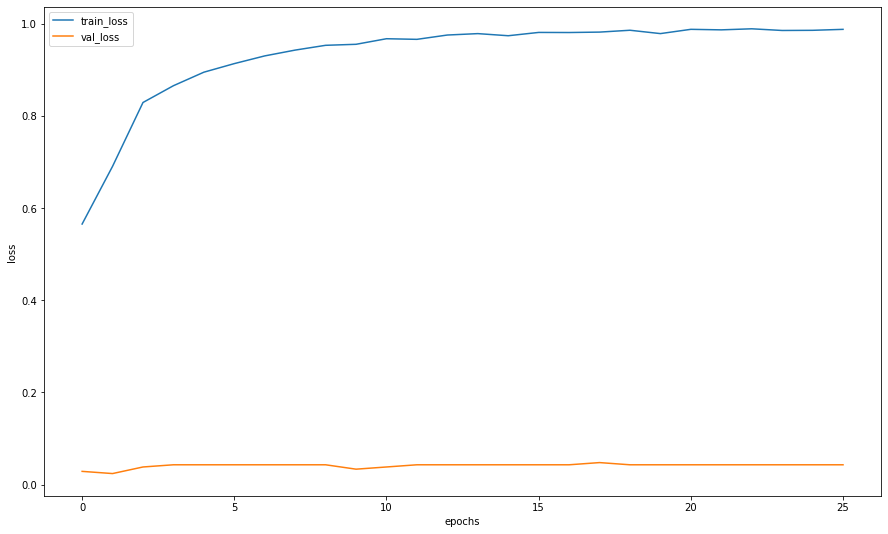

In [50]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_loss")
plt.plot(val_acc, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

In [54]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

random_characters = int(np.random.uniform(0,100))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_cnn, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,100, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_cnn, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [55]:
from sklearn.metrics import f1_score

In [56]:
f1_score(actual_labels, y_pred, average='macro')

0.07692307692307693

findfont: Font family ['fantasy'] not found. Falling back to DejaVu Sans.


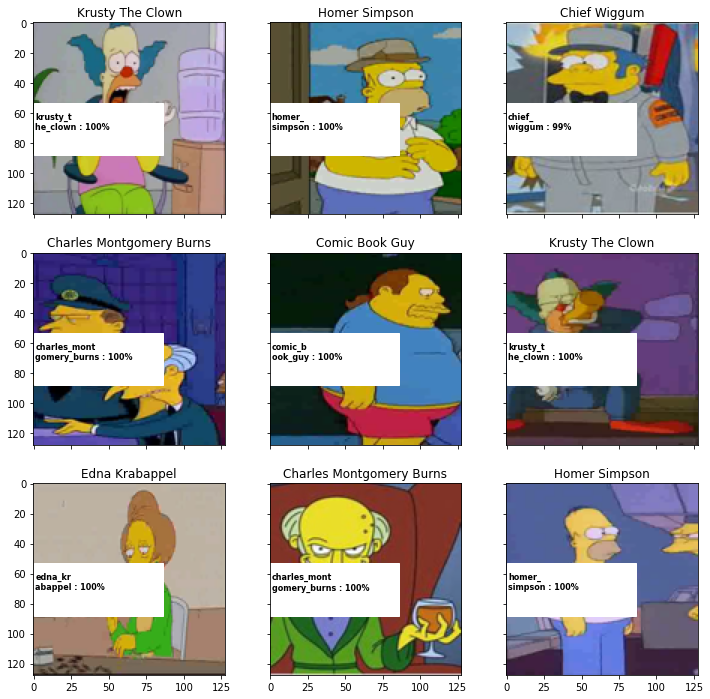

In [57]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,100))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(),\
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [58]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

probs = predict(model_cnn, test_loader)

In [59]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [60]:
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [61]:
import pandas as pd

my_submit = pd.DataFrame({'id': test_filenames, 'Expected': preds})
my_submit.head()

,id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [62]:
sub0 = pd.read_csv('./submisions/sub_densnet201_2.csv')

In [63]:
(sub0['Expected'] == my_submit['Expected']).value_counts(normalize=True)

True     0.964682
False    0.035318
Name: Expected, dtype: float64

In [64]:
# сохраняю предсказания для теста
my_submit.to_csv('./sub_model_4_densnet201.csv', index=False)

Полученная точность на kaggle: **0.97236**

Eсли будут какие-то вопросы, я в телеграмм:https://t.me/TT_Fl_B_E_Jl

P.S. спасибо за рецензию